In [68]:
import  warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import sklearn.metrics
import matplotlib.pyplot as plt
import gzip
import spacy
import seaborn as sns
from sklearn import svm
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [25]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

In [9]:
def getDF(path): 
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [142]:
ratings = getDF('reviews_Beauty_5.json.gz')

In [143]:
ratings.rename(columns={'reviewerID': 'user_id', 
                        'asin': 'item_id', 
                        'reviewerName': 'user_name', 
                        'reviewText': 'review_text',
                        'summary': 'review_summary',
                        'overall': 'score'},
               inplace=True)

ratings.user_id = ratings.user_id.astype('category').cat.codes.values
ratings.item_id = ratings.item_id.astype('category').cat.codes.values
# Add IDs for embeddings.
ratings['user_emb_id'] = ratings['user_id']
ratings['item_emb_id'] = ratings['item_id']

In [144]:
ratings.head()

,user_id,item_id,user_name,helpful,review_text,score,review_summary,unixReviewTime,reviewTime,user_emb_id,item_emb_id
0,5584,0,Andrea,"[3, 4]",Very oily and creamy. Not at all what I expect...,1.0,Don't waste your money,1391040000,"01 30, 2014",5584,0
1,17504,0,Jessica H.,"[1, 1]",This palette was a decent price and I was look...,3.0,OK Palette!,1397779200,"04 18, 2014",17504,0
2,14499,0,Karen,"[0, 1]",The texture of this concealer pallet is fantas...,4.0,great quality,1378425600,"09 6, 2013",14499,0
3,4157,0,Norah,"[2, 2]",I really can't tell what exactly this thing is...,2.0,Do not work on my face,1386460800,"12 8, 2013",4157,0
4,13219,0,Nova Amor,"[0, 0]","It was a little smaller than I expected, but t...",3.0,It's okay.,1382140800,"10 19, 2013",13219,0


In [79]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198502 entries, 0 to 198501
Data columns (total 11 columns):
user_id           198502 non-null int16
item_id           198502 non-null int16
user_name         197116 non-null object
helpful           198502 non-null object
review_text       198502 non-null object
score             198502 non-null float64
review_summary    198502 non-null object
unixReviewTime    198502 non-null int64
reviewTime        198502 non-null object
user_emb_id       198502 non-null int16
item_emb_id       198502 non-null int16
dtypes: float64(1), int16(4), int64(1), object(5)
memory usage: 13.6+ MB


In [88]:
score_list = sorted(ratings['score'].unique())
print('{0:20s} {1:5d}\t'.format('Score', len(score_list)), score_list)

Score                    5	 [1.0, 2.0, 3.0, 4.0, 5.0]


12101

In [152]:
# addind helpful rate
ratings['helpful_yes'] = ratings['helpful'].str.slice(0,1).str[0]
ratings['helpful_no'] = ratings['helpful'].str.slice(1,2).str[0]
ratings['helpful_total'] = ratings['helpful_yes'] + ratings['helpful_no']
ratings.loc[ratings['helpful_total'] > 0, 'helpful_rate'] = round(ratings['helpful_yes']/ratings['helpful_total'], 2)
ratings.head()

,user_id,item_id,user_name,helpful,review_text,score,review_summary,unixReviewTime,reviewTime,user_emb_id,item_emb_id,helpful_yes,helpful_no,helpful_total,helpful_rate
0,5584,0,Andrea,"[3, 4]",Very oily and creamy. Not at all what I expect...,1.0,Don't waste your money,1391040000,"01 30, 2014",5584,0,3,4,7,0.43
1,17504,0,Jessica H.,"[1, 1]",This palette was a decent price and I was look...,3.0,OK Palette!,1397779200,"04 18, 2014",17504,0,1,1,2,0.50
2,14499,0,Karen,"[0, 1]",The texture of this concealer pallet is fantas...,4.0,great quality,1378425600,"09 6, 2013",14499,0,0,1,1,0.00
3,4157,0,Norah,"[2, 2]",I really can't tell what exactly this thing is...,2.0,Do not work on my face,1386460800,"12 8, 2013",4157,0,2,2,4,0.50
4,13219,0,Nova Amor,"[0, 0]","It was a little smaller than I expected, but t...",3.0,It's okay.,1382140800,"10 19, 2013",13219,0,0,0,0,NaN


In [235]:
# set review summary as embedding
nlp_en = spacy.load('en', vectors='en_glove_cc_300_1m')
reviews = ratings["review_summary"]
embs = np.vstack([nlp_en(e).vector for e in reviews])

In [233]:
# set review summary combined with user id and item id as embedding
combined = ratings['review_summary'] + ' ' + ratings['user_emb_id'].astype(str) + ' ' + ratings['item_emb_id'].astype(str)
embs_combined = np.vstack([nlp_en(e).vector for e in combined])

n_samples: 132996, n_features: 384
accuracy:   0.753


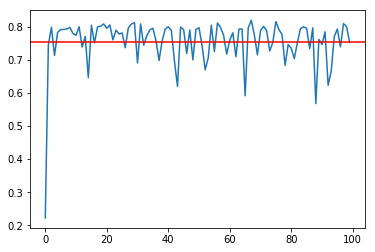

In [173]:
# Do classification with only review summary as embedding
# Using Perceptron
label = ratings['score'] >= 4
X_train, X_test, y_train, y_test = train_test_split(embs, label, test_size=0.33, random_state=42)
 
print("n_samples: %d, n_features: %d" % X_train.shape)

#Using Perceptron classifier
ites, scores = [], []
for i in range(100):
    ites.append(i)
    clf = Perceptron(n_iter = i)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    score = metrics.accuracy_score(y_test, pred)
    scores.append(score)
# Using random forest classifier
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)
pred = clf.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
#plot perceptron and random forest
plt.plot(ites, scores)
plt.axhline(y=score, color='r', linestyle='-')

n_samples: 132996, n_features: 384
accuracy:   0.805


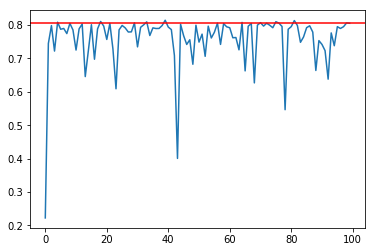

In [234]:
# Do classification with review summary combined with user id and item id as embeddings
# Using Perceptron
label = ratings['score'] >= 4
X_train, X_test, y_train, y_test = train_test_split(embs_combined, label, test_size=0.33, random_state=42)
 
print("n_samples: %d, n_features: %d" % X_train.shape)

#Using Perceptron classifier
ites, scores = [], []
for i in range(1，100):
    ites.append(i)
    clf = Perceptron(n_iter = i)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    score = metrics.accuracy_score(y_test, pred)
    scores.append(score)
# Using random forest classifier
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)
pred = clf.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
#plot perceptron and random forest
plt.plot(ites, scores)
plt.axhline(y=score, color='r', linestyle='-')

In [247]:
print('If use random forest, adding ids as embedding can improve our prediction restult.')
print('However, there is few improvement when using perceptron.')

If use random forest, adding ids as embedding can improve our prediction restult.
However, there is few improvement when using perceptron.


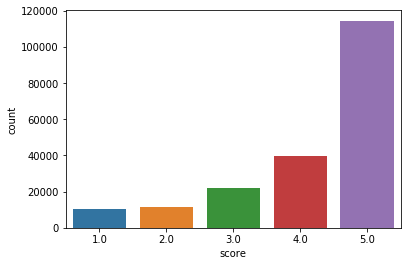

In [89]:
# Visualization of Scores of all items
sns.countplot(x='score', data=ratings)

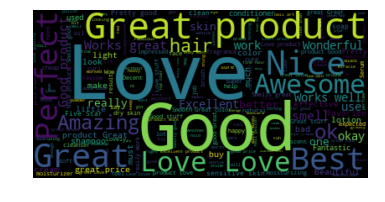

In [116]:
# Word Cloud
summary_str = ratings['review_summary'].to_string()
wordcloud = WordCloud(max_words=1000,margin=0).generate(summary_str)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

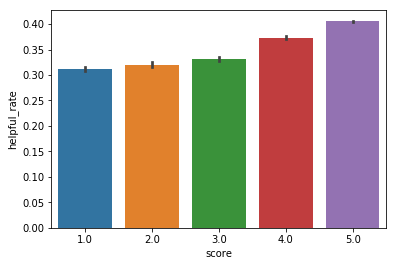

In [236]:
# Visualization of helpful rate
sns.barplot(x='score', y='helpful_rate', data=ratings)

In [238]:
#AB Test
a = ratings.loc[ratings['score'] < 4, 'helpful_rate']
b = ratings.loc[ratings['score'] >= 4, 'helpful_rate']
print(a.mean(), '\t', b.mean())

0.3222810921852084 	 0.3971322372435963


In [245]:
from scipy.stats import ttest_ind
print(ttest_ind(a, b, equal_var=False, nan_policy='omit'))
print('The helpful rate for customers who give 4.0 or above is significantly higher than that for customers who give low than 4.0 scores')

Ttest_indResult(statistic=-53.24222915694348, pvalue=0.0)
The helpful rate for customers who give 4.0 or above is significantly higher than that for customers who give low than 4.0 scores
